<a href="https://colab.research.google.com/github/MaLuWi/guayas_store_project/blob/main/Masterschool_Week2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima numpy==1.26.4

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('/content/drive/MyDrive/Time Series/df_train_filtered.csv') #this is the dataset after filtering out for the Guayas region and top3 familys
df_stores = pd.read_csv('/content/drive/MyDrive/Time Series/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/Time Series/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/Time Series/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/Time Series/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/Time Series/holidays_events.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-2-8ad3a3c4a99b>:11: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('/content/drive/MyDrive/Time Series/df_train_filtered.csv') #this is the dataset after filtering out for the Guayas region and top3 familys


# **Checking the datasets structure**

In [3]:
df_train.shape

(14745768, 6)

In [4]:
df_train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,18790,2013-01-02,24,105574,12.0,NaN
1,18791,2013-01-02,24,105575,2.0,NaN
2,18792,2013-01-02,24,105577,1.0,NaN
3,18793,2013-01-02,24,105693,7.0,NaN
4,18794,2013-01-02,24,105737,17.0,NaN


In [5]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [7]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [8]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [9]:
df_oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [10]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [11]:
# Before merging!
max_date = '2014-04-01'
df_train = df_train[df_train['date'] < max_date]

In [12]:
df_train.shape

(2747275, 6)

In [13]:
# let's assumne that train_df is the variable that has the data in it
# and df_stores is the dataframe that contains data about stores
# so you can merge these two dataframes like this:
df_train = df_train.merge(df_stores, on='store_nbr', how='left')

# let's also assume that df_items is the dataframe that
# contains data obout items. So, let's merge now
df_train = df_train.merge(df_items, on='item_nbr', how='left')


In [14]:
df_train.shape

(2747275, 13)

# **Datacleaning and Feature Engineering**

In [15]:
df_train.info() #in large datasets pandas skips counting non-null values to save time and memory
#Pandas automatically set onpromotion to 'object' because it contained: "False", "True", NaN - and could not understand if it's a bool or string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747275 entries, 0 to 2747274
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  object 
 6   city         object 
 7   state        object 
 8   type         object 
 9   cluster      int64  
 10  family       object 
 11  class        int64  
 12  perishable   int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 272.5+ MB


In [16]:
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,2747275
city,0
state,0
type,0
cluster,0


In [17]:
df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool) #first to bool.
df_train['onpromotion'] = df_train['onpromotion'].astype(int) #ML models work best with numbers + important for memory optimization
df_train.head()

<ipython-input-17-f663caae6815>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['onpromotion'] = df_train['onpromotion'].fillna(False).astype(bool) #first to bool.


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,family,class,perishable
0,18790,2013-01-02,24,105574,12.0,0,Guayaquil,Guayas,D,1,GROCERY I,1045,0
1,18791,2013-01-02,24,105575,2.0,0,Guayaquil,Guayas,D,1,GROCERY I,1045,0
2,18792,2013-01-02,24,105577,1.0,0,Guayaquil,Guayas,D,1,GROCERY I,1045,0
3,18793,2013-01-02,24,105693,7.0,0,Guayaquil,Guayas,D,1,GROCERY I,1034,0
4,18794,2013-01-02,24,105737,17.0,0,Guayaquil,Guayas,D,1,GROCERY I,1044,0


In [18]:
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
item_nbr,0
unit_sales,0
onpromotion,0
city,0
state,0
type,0
cluster,0


In [19]:
df_train.shape

(2747275, 13)

In [20]:
#Checking for negative sales which indicate product returns.
negative_sales = df_train[df_train['unit_sales'] < 0]
negative_sales.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster,family,class,perishable
13289,106658,2013-01-04,34,586824,-2.0,0,Guayaquil,Guayas,B,6,CLEANING,3090,0
38690,309805,2013-01-09,35,1079215,-8.0,0,Playas,Guayas,C,3,CLEANING,3022,0
45715,382905,2013-01-11,27,1097187,-20.0,0,Daule,Guayas,D,1,GROCERY I,1042,0
68451,564108,2013-01-15,51,627885,-36.0,0,Guayaquil,Guayas,A,17,GROCERY I,1030,0
94237,787522,2013-01-21,24,211205,-5.0,0,Guayaquil,Guayas,D,1,GROCERY I,1072,0


In [21]:
negative_sales.shape

(152, 13)

In [22]:
#Replacing negative sales with 0 to reflect returns as non-sales
df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x, 0))

In [23]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Get full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})
full_date_range

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
449,2014-03-27
450,2014-03-28
451,2014-03-29
452,2014-03-30


In [24]:
#Ok, now we have a list of all dates between the min and max date in our dataset! Next, let's create a DataFrame with all (store, item, date) combinations
# Create a DataFrame with all (store, item, date) combinations
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates() #This gives a DataFrame of all unique store-item pairs in df_train
all_combinations = store_item_combinations.merge(full_date_range, how='cross') #This creates a Cartesian product: Every store-item pair × every date in the range
all_combinations
# Why are we doing this?
#Because for time series forecasting, you need a complete time-indexed dataset, even for days with no sales, to ensure continuity
#This allows you to:
#->Fill missing dates
#->Set zero sales on dates with no transactions
#->Handle seasonality and lags correctly

,store_nbr,item_nbr,date
0,24,105574,2013-01-02
1,24,105574,2013-01-03
2,24,105574,2013-01-04
3,24,105574,2013-01-05
4,24,105574,2013-01-06
...,...,...,...
5219633,36,1112450,2014-03-27
5219634,36,1112450,2014-03-28
5219635,36,1112450,2014-03-29
5219636,36,1112450,2014-03-30


In [25]:
# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train, on=['store_nbr', 'item_nbr', 'date'], how='left') # Any missing sales will show as NaN in the unit_sales column after this.

# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0) #If a store-item-date combo had no recorded sale, this sets the value to zero.

# Check the first few rows
df_filled.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,city,state,type,cluster,family,class,perishable
0,24,105574,2013-01-02,18790.0,12.0,0.0,Guayaquil,Guayas,D,1.0,GROCERY I,1045.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0,Guayaquil,Guayas,D,1.0,GROCERY I,1045.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0,Guayaquil,Guayas,D,1.0,GROCERY I,1045.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0,Guayaquil,Guayas,D,1.0,GROCERY I,1045.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0,Guayaquil,Guayas,D,1.0,GROCERY I,1045.0,0.0


In [26]:
df_filled.shape

(5219638, 13)

In [27]:
df_train.shape

(2747275, 13)

In [28]:
df_train = df_filled
del df_filled

# **Applying the Model**

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [30]:
top_stores = (
    df_train.groupby('store_nbr')['unit_sales']
    .sum()
    .sort_values(ascending=False)
    .head(3)
    .index.tolist()
)


In [31]:
top_stores_sales = (
    df_train.groupby('store_nbr')['unit_sales']
    .sum()
    .sort_values(ascending=False)
    .head(3)
)

print(top_stores_sales)

store_nbr
51    3964017.000
24    3151987.000
34    2727649.752
Name: unit_sales, dtype: float64


In [32]:
# Option 1: Keep per-store daily data without summing
df_filtered1 = df_train[df_train['store_nbr'] == 51].copy()


In [33]:
df_filtered1 = df_filtered1.groupby('date').sum()['unit_sales'].reset_index()

In [34]:
# Fill missing dates with zero sales
df_filtered1.set_index('date', inplace=True)
df_filtered1 = df_filtered1.asfreq('D').fillna(0)

In [35]:
df_filtered1.head()

,unit_sales
date,
2013-01-02,10096.0
2013-01-03,7228.0
2013-01-04,7918.0
2013-01-05,10196.0
2013-01-06,10905.0


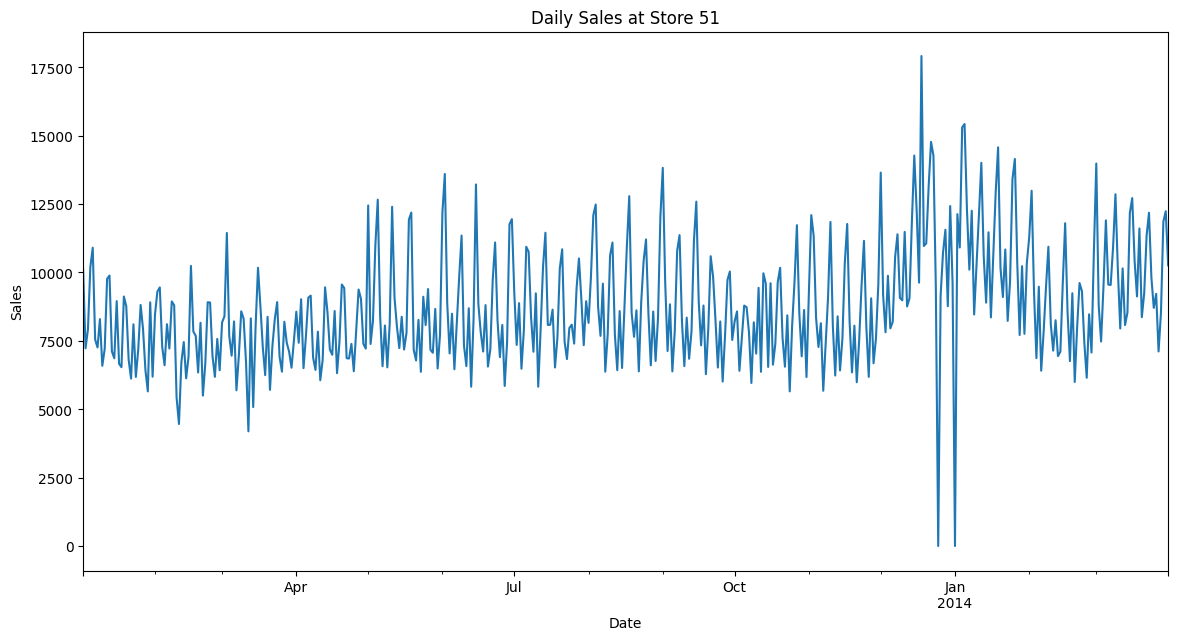

In [36]:
# Visualize sales data
plt.figure(figsize=(14, 7))
df_filtered1['unit_sales'].plot()
plt.title('Daily Sales at Store 51')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [41]:
df_filtered1['day_of_week'] = df_filtered1.index.dayofweek
df_filtered1['is_weekend'] = df_filtered1['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_filtered1['month'] = df_filtered1.index.month
df_filtered1['quarter'] = df_filtered1.index.quarter
df_filtered1['year'] = df_filtered1.index.year
df_filtered1['day_of_month'] = df_filtered1.index.day
df_filtered1['week_of_year'] = df_filtered1.index.isocalendar().week

In [42]:
# Create lag features (e.g., sales from the previous day, previous week)
df_filtered1['lag_1'] = df_filtered1['unit_sales'].shift(1)
df_filtered1['lag_7'] = df_filtered1['unit_sales'].shift(7)
df_filtered1['lag_30'] = df_filtered1['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
df_filtered1.dropna(inplace=True)

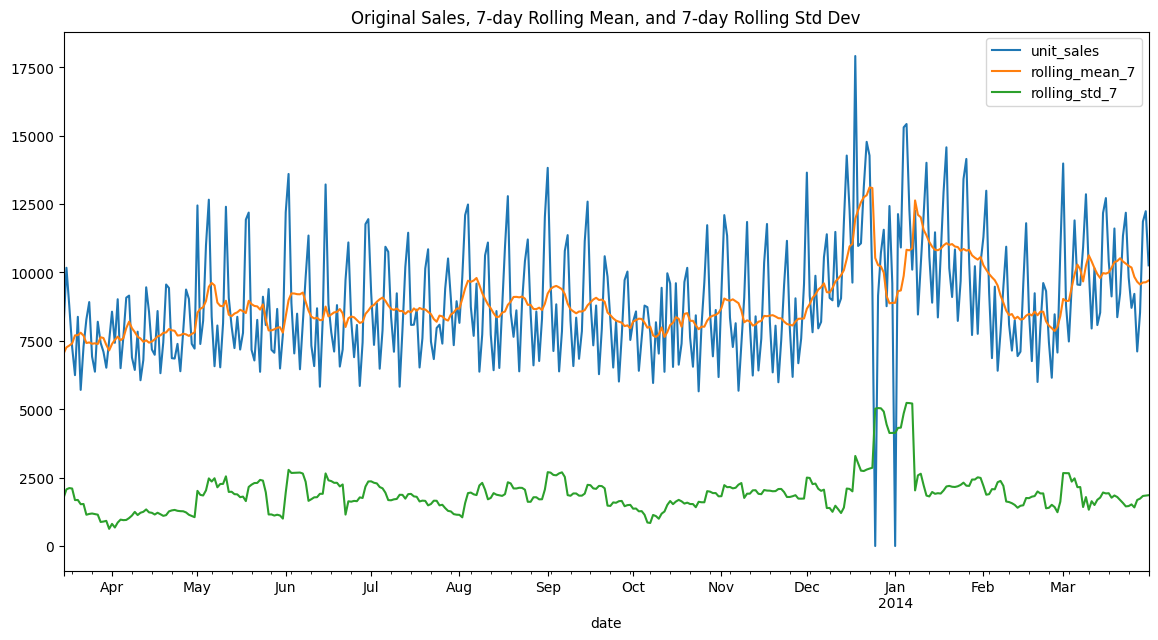

In [43]:
# Create rolling mean and rolling standard deviation features
df_filtered1['rolling_mean_7'] = df_filtered1['unit_sales'].rolling(window=7).mean()
df_filtered1['rolling_std_7'] = df_filtered1['unit_sales'].rolling(window=7).std()

# Drop any NaN values after creating rolling features
df_filtered1.dropna(inplace=True)

# Visualize the new features alongside the original sales
df_filtered1[['unit_sales', 'rolling_mean_7', 'rolling_std_7']].plot(figsize=(14, 7))
plt.title('Original Sales, 7-day Rolling Mean, and 7-day Rolling Std Dev')
plt.show()

In [44]:
# Define target variable (unit_sales) and features
X = df_filtered1.drop('unit_sales', axis=1)
y = df_filtered1['unit_sales']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [48]:
reg = xgb.XGBRegressor(
    n_estimators=1000,
    early_stopping_rounds=50 # if model doesn't improve, we stop
)

reg.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True)  # Change verbose to True if you want to see how the model gets trained

[0]	validation_0-rmse:1728.41325	validation_1-rmse:1882.01896
[1]	validation_0-rmse:1373.65340	validation_1-rmse:1587.87023
[2]	validation_0-rmse:1120.62496	validation_1-rmse:1567.65548
[3]	validation_0-rmse:922.71409	validation_1-rmse:1486.75727
[4]	validation_0-rmse:780.52334	validation_1-rmse:1424.66543
[5]	validation_0-rmse:680.18004	validation_1-rmse:1375.16891
[6]	validation_0-rmse:601.92689	validation_1-rmse:1387.06587
[7]	validation_0-rmse:545.57039	validation_1-rmse:1476.61942
[8]	validation_0-rmse:488.97250	validation_1-rmse:1473.34506
[9]	validation_0-rmse:450.94460	validation_1-rmse:1471.90641
[10]	validation_0-rmse:426.79032	validation_1-rmse:1450.01014
[11]	validation_0-rmse:408.53948	validation_1-rmse:1428.34899
[12]	validation_0-rmse:360.42740	validation_1-rmse:1434.70591
[13]	validation_0-rmse:333.78683	validation_1-rmse:1444.12541
[14]	validation_0-rmse:323.16074	validation_1-rmse:1449.10638
[15]	validation_0-rmse:288.22559	validation_1-rmse:1456.87095
[16]	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

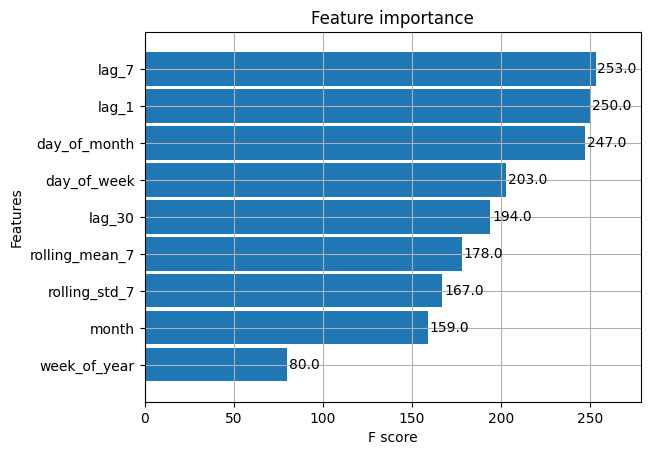

In [47]:
from xgboost import plot_importance, plot_tree
plot_importance(reg, height=0.9);

In [50]:
# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgboost_model.predict(X_test)

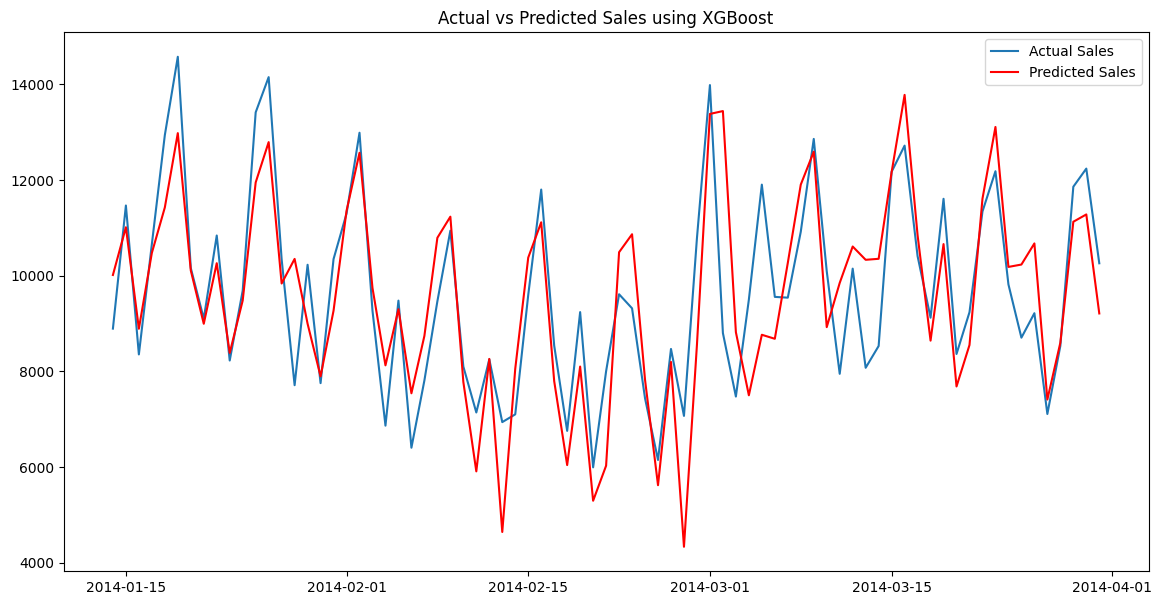

In [51]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()